### Merging Notebooks of Leiden clustered lymphoids and myeloids

#### Environment: Scanpy

- **Developed by**: Alexandra Cirnu
- **Modified by**: Alexandra Cirnu
- **Talavera-López Lab - Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 240507
- **Last modified**: 240509

##### Load required modules

In [145]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu
from muon import atac as ac
from muon import prot as pt
from scipy.sparse import csr_matrix

In [146]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 10.2.0
asttokens           NA
colorama            0.4.6
comm                0.2.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.1
decorator           5.1.1
exceptiongroup      1.2.0
executing           2.0.1
h5py                3.10.0
igraph              0.11.4
ipykernel           6.29.2
ipywidgets          8.1.2
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.2
llvmlite            0.42.0
matplotlib          3.8.3
matplotlib_inline   0.1.6
mpl_toolkits        NA
mudata              0.2.3
muon                0.1.5
natsort             8.4.0
numba               0.59.0
numpy               1.26.4
packaging           23.2
pandas              2.2.1
parso               0.8.3
patsy               0.5.6
pickleshare         0.7.5
platformdirs        4.2.0
prompt_toolkit      3.0.42
psutil              5.9.8
pure_eva

In [147]:
def X_is_raw(adata): return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Read in both MuData sets that were clustered with `leiden`

In [148]:
mdata_myeloid = mu.read_h5mu('/home/acirnu/data/ACM_cardiac_leuco/5_Leiden_clustering_and_annotation/ACM_myeloids_leiden_clustering_muon_ac240502.raw.h5mu')
mdata_myeloid

/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 34482 × 29477
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	34482 x 29378
      obs:	'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden'
      var:	'gene_ids', 'feature_types', 'mt', 'ribo'
      uns:	'C_scANVI_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap'
      obsp:	'connectivities', 'distances'
    prot:	34482 x 99
      obs:	'library', 'batch'
      var:	'gene_ids', 'feature_types'
      uns:	'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log_norm'

In [149]:
mdata_lymphoid = mu.read_h5mu('/home/acirnu/data/ACM_cardiac_leuco/5_Leiden_clustering_and_annotation/ACM_lymphoids_leiden_clustering_muon_ac240506.raw.h5mu')
mdata_lymphoid

/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 10104 × 29477
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	10104 x 29378
      obs:	'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden'
      var:	'gene_ids', 'feature_types', 'mt', 'ribo'
      uns:	'C_scANVI_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap'
      obsp:	'connectivities', 'distances'
    prot:	10104 x 99
      obs:	'library', 'batch'
      var:	'gene_ids', 'feature_types'
      uns:	'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log_norm'

### Split the MuData objects to single AnnData obejcts

In [150]:
myeloid_rna = mdata_myeloid.mod['rna']
lymphoid_rna = mdata_lymphoid.mod['rna']
 
myeloid_prot = mdata_myeloid.mod['prot']
lymphoid_prot = mdata_lymphoid.mod['prot']

In [151]:
myeloid_rna.obs['classification'] = myeloid_rna.obs['leiden'].copy()
lymphoid_rna.obs['classification'] = lymphoid_rna.obs['leiden'].copy()

In [152]:
label_mapping = {
    '0': 'MØ_general_0',
    '1': 'LYVE1+MØ_1',
    '2': 'LYVE1+MØ_2',
    '3': 'DOCK4+MØ_3',
    '4': 'LYVE1+MØ_4',
    '5': 'Neutrophils_5',
    '6': 'Monocytes_6',
    '7': 'MØ_general_7',
    '8': 'LYVE1+MØ_8',
    '9': 'DOCK4+MØ_9',
    '10': 'MØ_general_10',
    '11': 'Monocytes_11',
    '12': 'DC_12',
    '13': 'Monocytes_13',
    '14': 'DC_14',
    '15': 'Mast_15',
    '16': 'DC_16',
    '17': 'Monocytes_17'
}

# Apply the mapping to the 'classification' column
myeloid_rna.obs['classification'] = myeloid_rna.obs['classification'].astype(str).replace(label_mapping)

In [153]:
label_mapping = {
    '0': 'CD8_0',
    '1': 'CD8_1',
    '2': 'B_2',
    '3': 'CD4_3',
    '4': 'CD4_4',
    '5': 'NK_5',
    '6': 'CD4_6',
    '7': 'CD8_7',
    '8': 'CD4_8',
    '9': 'B_9',
    '10': 'CD4_10',
    '11': 'CD4_11',
    '12': 'B_12',
    '13': 'B_13',
    '14': 'NKT_14',
    '15': 'CD4_15',
    '16': 'CD4_16',
    '17': 'B_17'
}

# Apply the mapping to the 'classification' column explicitly converting to string
lymphoid_rna.obs['classification'] = lymphoid_rna.obs['classification'].astype(str).replace(label_mapping)

### Concatenate the **rna** and the **prot** AnnData objects separately

In [154]:
rna = sc.concat([myeloid_rna, lymphoid_rna], join = 'inner', merge = 'same', uns_merge = 'same', label = 'lineage', keys = ['myeloid', 'lymphoid']) 
rna.var_names_make_unique()  
rna 

AnnData object with n_obs × n_vars = 44586 × 29378
    obs: 'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden', 'classification', 'lineage'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo'
    uns: 'leiden', 'leiden_colors', 'neighbors'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [155]:
rna.obs

,cell_source,donor,n_counts,sample,seed_labels,condition,genotype,infection,library,model,...,XIST-counts,S_score,G2M_score,_scvi_batch,_scvi_labels,batch,C_scANVI,leiden,classification,lineage
AAACGCTGTTGTGTTG-1-A1,AG_Gerull,Pkp2_Ctr_noninf_1,478.0,Pkp2_Ctr_noninf_1,DOCK4+MØ,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,0.0,-0.019995,-0.083225,6,1,reference,DOCK4+MØ,3,DOCK4+MØ_3,myeloid
AAACGCTTCTCGCTCA-1-A1,AG_Gerull,Pkp2_Ctr_noninf_1,3581.0,Pkp2_Ctr_noninf_1,Monocytes,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,0.0,-0.169221,-0.390143,6,4,reference,Monocytes,3,DOCK4+MØ_3,myeloid
AAAGGTACAGAACATA-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,16539.0,Pkp2_Ctr_noninf_2,Monocytes,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,0.0,-0.317631,-0.578955,7,4,reference,Monocytes,6,Monocytes_6,myeloid
AAAGTCCAGGGACACT-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,13389.0,Pkp2_Ctr_noninf_2,LYVE1+MØ,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,0.0,-0.370103,-0.370084,7,2,reference,LYVE1+MØ,2,LYVE1+MØ_2,myeloid
AAAGTCCCAGTAGGAC-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,12092.0,Pkp2_Ctr_noninf_2,LYVE1+MØ,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,0.0,-0.142503,-0.357287,7,2,reference,LYVE1+MØ,2,LYVE1+MØ_2,myeloid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCAGTATGACA-1-B2,AG_Gerull,Ttn_HetKO_MCMV_1,12119.0,Ttn_HetKO_MCMV_1,Unknown,Ttn_HetKO_MCMV,Ttn_HetKO,MCMV,B2,Ttn,...,0.0,-0.267751,-0.531946,25,5,query,B,9,B_9,lymphoid
TTTGGAGAGATTAGCA-1-B2,AG_Gerull,Ttn_Ctr_MCMV_2,20506.0,Ttn_Ctr_MCMV_2,Unknown,Ttn_Ctr_MCMV,Ttn_Ctr,MCMV,B2,Ttn,...,23.0,2.905558,0.470866,21,5,query,B,2,B_2,lymphoid
TTTGGTTAGCACCTGC-1-B2,AG_Gerull,Ttn_HetKO_MCMV_2,3174.0,Ttn_HetKO_MCMV_2,Unknown,Ttn_HetKO_MCMV,Ttn_HetKO,MCMV,B2,Ttn,...,0.0,0.000996,-0.736926,26,5,query,CD8,7,CD8_7,lymphoid
TTTGTTGAGACCTCCG-1-B2,AG_Gerull,Ttn_HetKO_noninf_2,4549.0,Ttn_HetKO_noninf_2,Unknown,Ttn_HetKO_noninf,Ttn_HetKO,noninf,B2,Ttn,...,0.0,-0.428444,-0.362500,29,5,query,B,13,B_13,lymphoid


In [156]:
prot = sc.concat([myeloid_prot, lymphoid_prot], join = 'inner', merge = 'same', uns_merge = 'same', label = 'lineage', keys = ['myeloid', 'lymphoid']) 
prot.var_names_make_unique()  
prot 

AnnData object with n_obs × n_vars = 44586 × 99
    obs: 'library', 'batch', 'lineage'
    var: 'gene_ids', 'feature_types'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log_norm'

In [157]:
prot.obs

,library,batch,lineage
AAACGCTGTTGTGTTG-1-A1,A1,reference,myeloid
AAACGCTTCTCGCTCA-1-A1,A1,reference,myeloid
AAAGGTACAGAACATA-1-A1,A1,reference,myeloid
AAAGTCCAGGGACACT-1-A1,A1,reference,myeloid
AAAGTCCCAGTAGGAC-1-A1,A1,reference,myeloid
...,...,...,...
TTTGATCAGTATGACA-1-B2,B2,query,lymphoid
TTTGGAGAGATTAGCA-1-B2,B2,query,lymphoid
TTTGGTTAGCACCTGC-1-B2,B2,query,lymphoid
TTTGTTGAGACCTCCG-1-B2,B2,query,lymphoid


### Re-calculate neighbors for UMAP representation

In [158]:
rna

AnnData object with n_obs × n_vars = 44586 × 29378
    obs: 'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden', 'classification', 'lineage'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo'
    uns: 'leiden', 'leiden_colors', 'neighbors'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [159]:
del(rna.uns['neighbors'])

In [160]:
sc.pp.neighbors(rna, use_rep = "X_scANVI", n_neighbors = 150, metric = 'minkowski')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:37)


In [167]:
sc.tl.umap(rna, min_dist = 1.5, spread = 8, random_state = 1712)

computing UMAP


/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:31)


/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(val

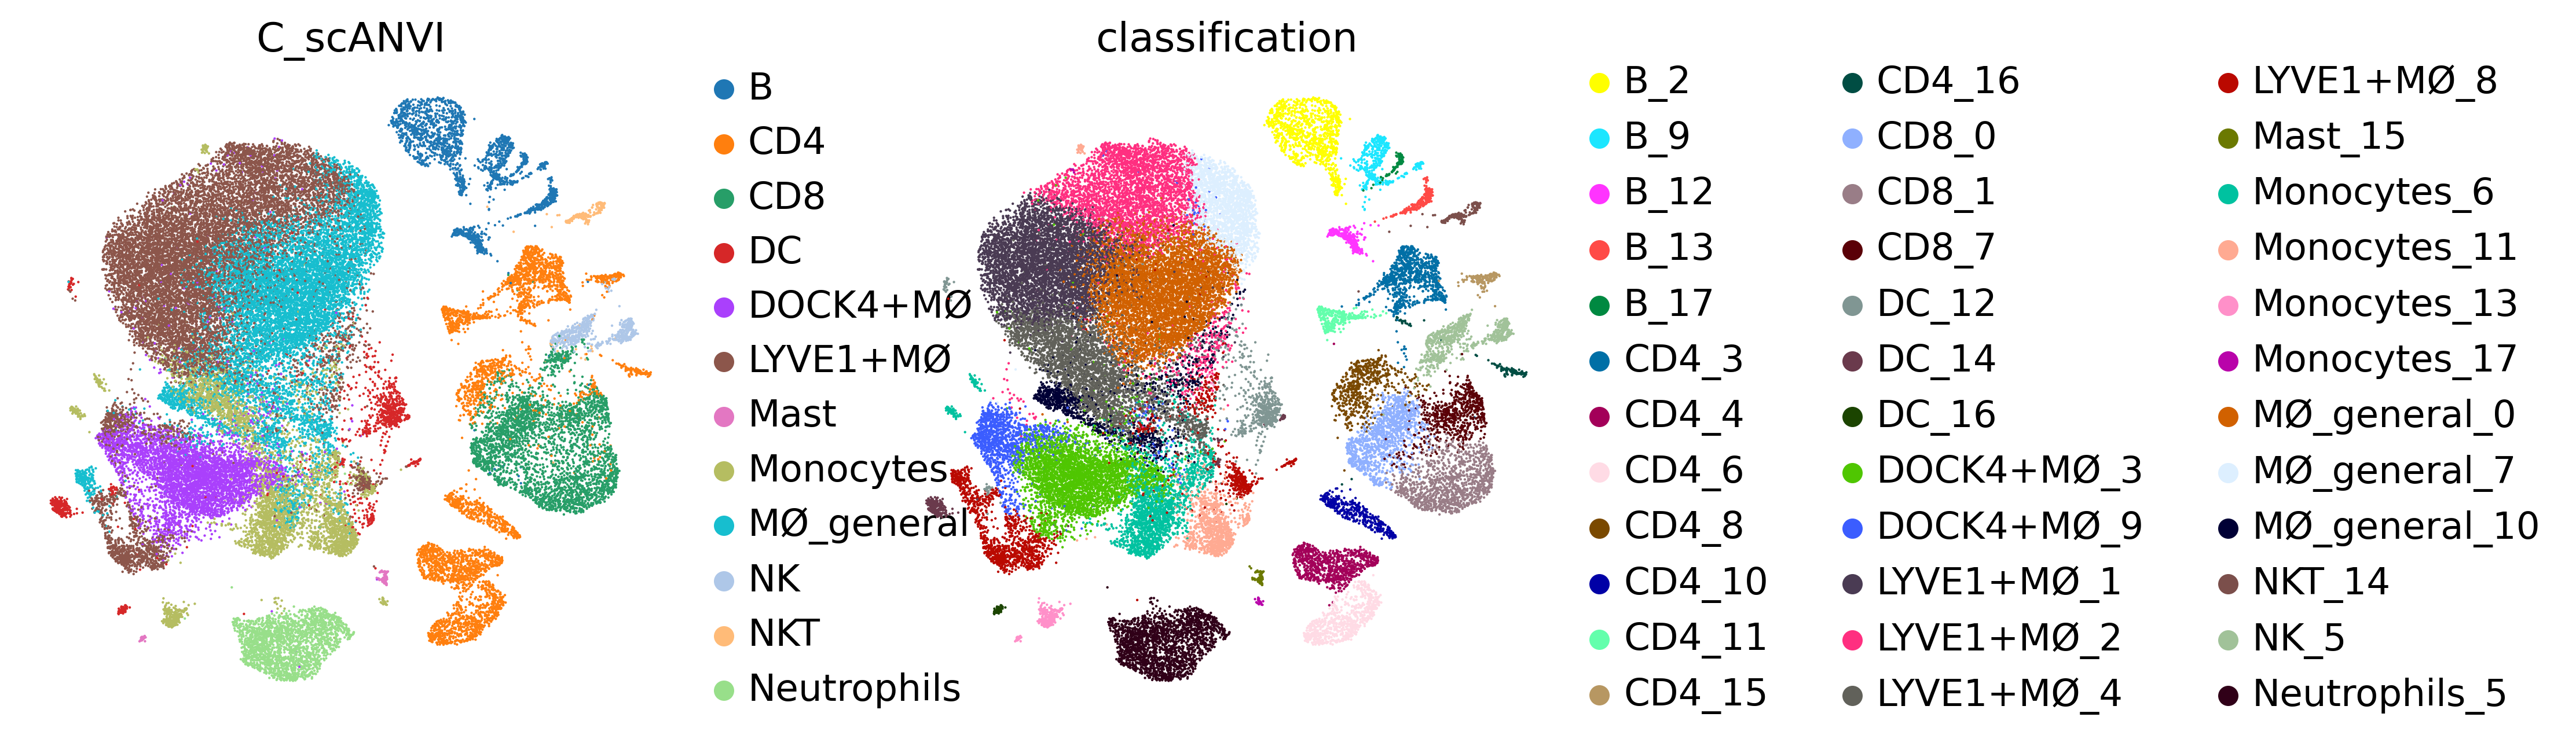

In [168]:
sc.pl.umap(rna, color=['C_scANVI', 'classification'], size = 3, frameon = False)

### Check if raw data is stored in merged adata object

In [169]:
print(X_is_raw(rna))
print(X_is_raw(prot))

True
True


### Create a merged MuData object

In [170]:
mdata = mu.MuData({'rna': rna, 'prot': prot})
mdata.var_names_make_unique()  
mdata

MuData object with n_obs × n_vars = 44586 × 29477
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	44586 x 29378
      obs:	'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden', 'classification', 'lineage'
      var:	'gene_ids', 'feature_types', 'mt', 'ribo'
      uns:	'leiden', 'leiden_colors', 'neighbors', 'umap', 'C_scANVI_colors', 'classification_colors'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap'
      obsp:	'distances', 'connectivities'
    prot:	44586 x 99
      obs:	'library', 'batch', 'lineage'
      var:	'gene_ids', 'feature_types'
      uns:	'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log_norm'

In [171]:
#for modality in mdata.mod.values():
#    modality.obs_names_make_unique()

mdata.update()
mdata

MuData object with n_obs × n_vars = 44586 × 29477
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	44586 x 29378
      obs:	'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden', 'classification', 'lineage'
      var:	'gene_ids', 'feature_types', 'mt', 'ribo'
      uns:	'leiden', 'leiden_colors', 'neighbors', 'umap', 'C_scANVI_colors', 'classification_colors'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap'
      obsp:	'distances', 'connectivities'
    prot:	44586 x 99
      obs:	'library', 'batch', 'lineage'
      var:	'gene_ids', 'feature_types'
      uns:	'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log_norm'

## Save merged object

In [172]:
mdata.write("/home/acirnu/data/ACM_cardiac_leuco/5_Leiden_clustering_and_annotation/ACM_myeloids+lymphoids_leiden_clustered_muon_ac240507.raw.h5mu") 

/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
